# Ej1: Clasificación de rostros: ViT

In [ ]:
import copy
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv
import torchvision.transforms as T


from tqdm.auto import trange
from einops import rearrange

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula
ROWS, COLS = 4, 8

N_EPOCAS = 30
T_LOTE = 64
T_IMG = (32, 32)
NUM_WORKERS = 4
N_IMGS_MUESTRA = 36

T_PARCHES = 8 # tamaño de los parches
D_EMBED = 128 # tamaño de los embeddings
N_CABEZAS = 8  # numero de cabezas de autoatención
N_CAPAS = 6 # numero de bloques Transformers
RDP_DIM = 512 # tamaño de salidas de red hacia adelante por posición
P_DROPOUT = 0.2

LOGDIR = './runs/'
DISP = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

np.random.seed(42)
th.random.manual_seed(42)

In [ ]:
data = load_dataset("HuggingFaceM4/FairFace", "0.25")
print(data)


class HF_FairFace(Dataset):
    """
    Envuelve el split de HuggingFace en un Dataset de PyTorch.

    Cada elemento tiene:
      - image: tensor normalizado en [-1, 1]
      - age:   entero con el grupo etario [0..7]
    """
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item["image"]   # PIL.Image
        label = item["age"]     # entero [0..7]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

val_tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

In [ ]:
class ProductoPuntoEscalado(nn.Module):
  def __init__(self):
    super(ProductoPuntoEscalado, self).__init__()

  def forward(self, Q, K, V):
    # Obtenemos dimensiones
    m, n_cabezas, l, d_k = K.shape
    d_v = V.shape[-1]
    Q = Q.reshape(m * n_cabezas, l, d_k)
    K = K.reshape(m * n_cabezas, l, d_k)
    V = V.reshape(m * n_cabezas, l, d_v)
    QK = th.bmm(Q, K.transpose(1, 2))
    QK_esc = QK / th.math.sqrt(d_k)
    alfas = nn.functional.softmax(QK_esc, dim = -1)
    Y = th.bmm(alfas, V)
    Y = Y.reshape(m, n_cabezas, l, d_v)
    alfas = alfas.reshape(m, n_cabezas, l, l)

    return Y, alfas



class AtencionMulticabeza(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas):
    super(AtencionMulticabeza, self).__init__()

    self.n_cabezas = n_cabezas
    self.d_modelo = d_modelo
    self.d_k = self.d_modelo // self.n_cabezas

    self.ppe = ProductoPuntoEscalado()

    self.proy_Q = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_K = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_V = nn.Linear(self.d_modelo, self.d_modelo, bias = False)

    self.proy_sal = nn.Linear(self.d_modelo, self.d_modelo)

  def forward(self, x):
    m, l, d_modelo = x.shape
    Q = self.proy_Q(x)
    K = self.proy_K(x)
    V = self.proy_V(x)

    Q = Q.reshape(m, l, self.n_cabezas, self.d_k)
    K = K.reshape(m, l, self.n_cabezas, self.d_k)
    V = V.reshape(m, l, self.n_cabezas, self.d_k)

    Q = Q.transpose(1, 2).contiguous()
    K = K.transpose(1, 2).contiguous()
    V = V.transpose(1, 2).contiguous()

    Y, alfas = self.ppe(Q, K, V)

    Y = Y.transpose(1, 2).contiguous()

    Y = Y.reshape(m, l, self.d_modelo)

    Y = self.proy_sal(Y)

    return Y, alfas

class RedDensaPosicion(nn.Module):
  def __init__(self,
               d_modelo,
               d_rdp,
               p_dropout):
    super(RedDensaPosicion, self).__init__()

    self.d_modelo = d_modelo
    self.d_rdp = d_rdp

    self.densa1 = nn.Linear(self.d_modelo, self.d_rdp)
    self.densa2 = nn.Linear(self.d_rdp, self.d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)
    self.dropout2 = nn.Dropout(p_dropout)

  def forward(self, x):
    m, l, d_modelo = x.shape

    x = nn.functional.gelu(x)
    x = self.dropout1(x)

    x = self.densa2(x)
    x = self.dropout2(x)

    return x



class BloqueTransformer(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               d_rdp,
               p_dropout = 0.0):
    super(BloqueTransformer, self).__init__()

    self.amc = AtencionMulticabeza(d_modelo = d_modelo,
                                   n_cabezas = n_cabezas)
    self.norm1 = nn.LayerNorm(d_modelo)
    self.norm2 = nn.LayerNorm(d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)

    self.mlp = RedDensaPosicion(d_modelo, d_rdp, p_dropout)

  def forward(self, x):
    x_ln1 = self.norm1(x)
    salidas_amc, alfas = self.amc(x_ln1)
    salidas_amc = self.dropout1(salidas_amc)

    x = salidas_amc + x
    x_ln2 = self.norm2(x)
    mlp = self.mlp(x_ln2)
    out = mlp + x

    return out


In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size,
               t_parches,
               n_clases,
               d_embed,
               n_capas,
               n_cabezas,
               rdp_dim,
               p_dropout):
    super().__init__()

    self.d_embed = d_embed
    self.n_clases = n_clases
    self.t_parches = t_parches
    self.n_parches = (img_size // t_parches) ** 2

    input_projection = (t_parches * t_parches * 3) # P x P x C
    self.projection = nn.Linear(input_projection, d_embed)
    self.pos_embedding = nn.Parameter(th.randn(1,
                                               self.n_parches + 1, d_embed))
    self.cls_token = nn.Parameter(th.randn(1, 1, d_embed))
    bloques = [BloqueTransformer(d_embed,
                                 n_cabezas,
                                 rdp_dim,
                                 p_dropout) for _ in range(n_capas)]
    self.transformer = nn.Sequential(*bloques)
    self.classifier = nn.Sequential(nn.LayerNorm(d_embed),
                                    nn.Linear(d_embed, n_clases))

  def forward(self, x):
    m = x.shape[0]
    parches = rearrange(x,
                        'm c (patch_x x) (patch_y y) -> m (x y) (patch_x patch_y c)',
                        patch_x = self.t_parches, patch_y = self.t_parches)
    x = self.projection(parches)
    cls_token = self.cls_token.repeat(m, 1, 1)

    x = th.cat((cls_token, x), dim = 1)
    x += self.pos_embedding
    x = self.transformer(x)
    x = x[:, 0, :]

    x = self.classifier(x)

    return x

modelo = ViT(T_IMG[0],
             t_parches = T_PARCHES,
             n_clases = len(c2i),
             d_embed = D_EMBED,
             n_capas = N_CAPAS,
             n_cabezas = N_CABEZAS,
             rdp_dim = RDP_DIM,
             p_dropout = P_DROPOUT)
modelo(th.rand(1, 3, T_IMG[0], T_IMG[1])).shape

In [ ]:
class Residual(nn.Module):
  def __init__(self,
               cent,
               csal,
               downsample = False):
    super(Residual, self).__init__()

    stride = 1

    if downsample:
      stride = 2

    if cent != csal or downsample:
      self.conv1x1 = nn.Conv2d(cent, csal, 1, stride = stride, padding = 0)
    else:
      self.conv1x1 = None

    self.conv1 = nn.Conv2d(cent, csal, 3, stride = stride, padding = 1)
    self.bn1 = nn.BatchNorm2d(csal)
    self.conv2 = nn.Conv2d(csal, csal, 3, padding = 'same')
    self.bn2 = nn.BatchNorm2d(csal)

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = nn.functional.relu(y)
    y = self.conv2(y)
    y = self.bn2(y)

    if self.conv1x1:
      x = self.conv1x1(x)

    return nn.functional.relu(x + y)


class BloqueResNet(nn.Module):
  def __init__(self,
               cent,
               csal,
               k = 2,
               downsample = False):
    super(BloqueResNet, self).__init__()

    self.res = [Residual(cent, csal, downsample = downsample)]
    for i in range(1, k):
      self.res.append(Residual(csal, csal))
    self.res = nn.ModuleList(self.res)

  def forward(self, x):
    for r in self.res:
      x = r(x)
    return x

In [ ]:
class ViT_ResNet(nn.Module):
  def __init__(self,
               img_size,
               t_parches,
               n_clases,
               d_embed,
               n_capas,
               n_cabezas,
               rdp_dim,
               p_dropout):
    super().__init__()

    self.d_embed = d_embed
    self.n_clases = n_clases
    self.t_parches = t_parches
    self.n_parches = (img_size // t_parches) ** 2

    input_projection = (t_parches * t_parches * 3) # P x P x C
    self.resnet = nn.BloqueResNet(input_projection, d_embed)
    self.pos_embedding = nn.Parameter(th.randn(1,
                                               self.n_parches + 1, d_embed))
    self.cls_token = nn.Parameter(th.randn(1, 1, d_embed))
    bloques = [BloqueTransformer(d_embed,
                                 n_cabezas,
                                 rdp_dim,
                                 p_dropout) for _ in range(n_capas)]
    self.transformer = nn.Sequential(*bloques)
    self.classifier = nn.Sequential(nn.LayerNorm(d_embed),
                                    nn.Linear(d_embed, n_clases))

  def forward(self, x):
    m = x.shape[0]
    parches = rearrange(x,
                        'm c (patch_x x) (patch_y y) -> m (x y) (patch_x patch_y c)',
                        patch_x = self.t_parches, patch_y = self.t_parches)
    x = self.projection(parches)
    cls_token = self.cls_token.repeat(m, 1, 1)

    x = th.cat((cls_token, x), dim = 1)
    x += self.pos_embedding
    x = self.transformer(x)
    x = x[:, 0, :]

    x = self.classifier(x)

    return x

modelo = ViT_ResNet(T_IMG[0],
             t_parches = T_PARCHES,
             n_clases = len(c2i),
             d_embed = D_EMBED,
             n_capas = N_CAPAS,
             n_cabezas = N_CABEZAS,
             rdp_dim = RDP_DIM,
             p_dropout = P_DROPOUT)
modelo(th.rand(1, 3, T_IMG[0], T_IMG[1])).shape

In [ ]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso



def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
    'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
    'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for Xlote,ylote in entdl:
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with th.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)
      perdida_min = hist['val']['perdida'][e]

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'Época {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

In [ ]:
modelo = modelo.to(DISP)

perdida = nn.CrossEntropyLoss(weight = None,
                              reduction = 'mean')
opt = th.optim.Adam(modelo.parameters(),
                    lr = 0.0001,
                    weight_decay = 0.0001)

modelo, mejor_modelo, hist = entrena(modelo,
                                     perdida,
                                     exactitud,
                                     opt,
                                     ent_dl,
                                     val_dl,
                                     DISP,
                                     LOGDIR + '/vit.pt',
                                     n_epocas = N_EPOCAS,
                                     tbdir = LOGDIR)

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

# Ej2: Reconocimiento de comandos de voz

La importación de datos se hace basándonos en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1d_procesamiento_audio.ipynb). La red ya es una implementación personal.

## 2.1 Datos, Dataset, y Dataloader

In [1]:
import random
import librosa
import IPython as ip
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from tqdm.auto import trange
import collections

In [2]:
speech_ds = SPEECHCOMMANDS(r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets', download = False) # download = True solo si no lo predescargaste

In [3]:
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


In [4]:
# Parámetros. (Extraídos del notebook)
BATCH_SIZE = 32
SECS = 1
SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = N_FFT // 2

class MySpeechCommands(SPEECHCOMMANDS):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, 
               root, 
               download = False, 
               subset = None,
               waveform_tsfm = None, 
               label_tsfm = None):
        super().__init__(root = root, download = download, subset = subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
    
    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
    
        if self.waveform_tsfm:
            x = self.waveform_tsfm(waveform)
        
        if self.label_tsfm:
            y = self.label_tsfm(label)
          
        return x, y, label, sample_rate
      
class WaveformPadTruncate(nn.Module):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, secs = SECS, sample_rate = SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate
    
    def forward(self, waveform):
        samples = waveform.shape[1]
    
        if samples < self.samples:
            difference = self.samples - samples
            padding = th.zeros(1, difference)
            waveform = th.cat([waveform, padding], 1)
        
        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)
            
        return waveform

def label2index(label):
    return CLASS_IDX[label]

In [5]:
# Creación del dataset y dataloader.
ds = MySpeechCommands(
  root = r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets',
  waveform_tsfm = WaveformPadTruncate(),
  label_tsfm = label2index,
)

# creamos un DataLoader
dl = DataLoader(
  ds,
  batch_size = BATCH_SIZE,
  shuffle = True)

In [6]:
# Visualización de datos
x, y, label, sr = next(iter(dl))
print(f'x shape = {x.shape} dtype = {x.dtype}')
print(f'y shape = {y.shape} dtype = {y.dtype}')
print(f'label = {label} type = {type(label)}')
print(f'sr tensor shape = {sr.shape} type = {type(sr)}')

x shape = torch.Size([32, 1, 16000]) dtype = torch.float32
y shape = torch.Size([32]) dtype = torch.int64
label = ('right', 'stop', 'up', 'go', 'happy', 'backward', 'four', 'left', 'house', 'two', 'five', 'four', 'bird', 'backward', 'zero', 'right', 'right', 'five', 'learn', 'marvin', 'six', 'backward', 'wow', 'seven', 'six', 'zero', 'marvin', 'marvin', 'house', 'two', 'yes', 'two') type = <class 'tuple'>
sr tensor shape = torch.Size([32]) type = <class 'torch.Tensor'>


## 2.2 Red Neuronal basada en Transformers

In [7]:
%%time
class RedNeuronal(nn.Module):
    def __init__(self):
        """
        La red consta de un bloque transformer con 2 bloques de: 4 Encoders y 2 Decoders. (Se usan estas cantidades debido a restricciones de cómputo)
        """
        super().__init__()
        self.enc_layer = nn.TransformerEncoderLayer(d_model = 16000, nhead = 4)
        self.dec_layer = nn.TransformerDecoderLayer(d_model = 16000, nhead = 2)
        self.proc1 = nn.TransformerEncoder(self.enc_layer, num_layers = 1)
        self.proc2 = nn.TransformerDecoder(self.dec_layer, num_layers = 1)
        self.classification = nn.Linear(16000, NUM_CLASSES)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        enc = self.proc1(x)
        dec = self.proc2(enc,enc)
        last_token = dec[-1, :, :]
        logits = self.classification(last_token) # New value
        softmax = self.softmax(logits)
        output = softmax.argmax(1)
        return output

red_cabrona = RedNeuronal()
actual_logits = red_cabrona(x) 
print(actual_logits)

C:\Users\FLopezP\Anaconda3\envs\ayuda_por_favor\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([24])
CPU times: total: 43.4 s
Wall time: 13.3 s


In [8]:
def train_loop(dataloader, model, lf, optimizer):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    optimizer -> Pues un optimizer bb
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        X = data[0]
        target = data[1][0]
        target = th.Tensor([target]).long()
        pred = model(X)
        target = target.long()
        pred = pred.type(th.float32)
        target = target.type(th.float32)
        
        pred.requires_grad_(True)
        
        loss = lf(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print("Loss: {}. [{}/{}]".format(round(loss, 4), current, size))

def test_loop(dataloader, model, lf):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    """
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += lf(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

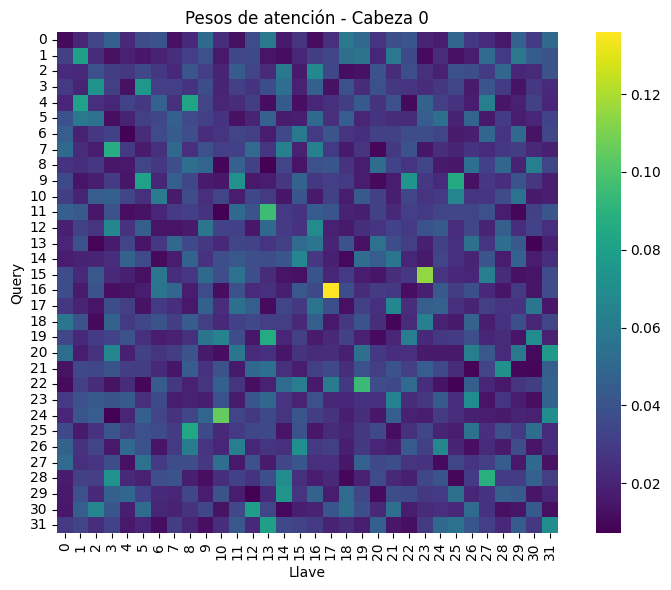

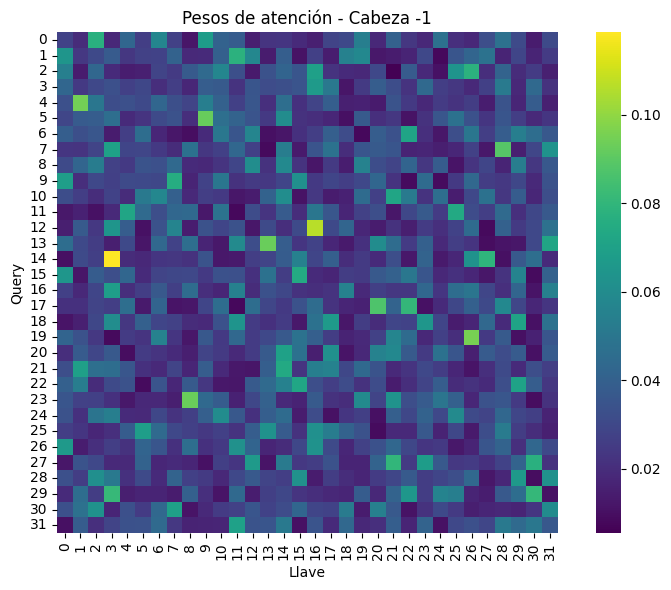

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, input_data):
    """
    Extrae y visualiza los valroes de atención de la capa a partir de un input.
    
    model-> red_cabrona()
    input_data-> Tensor de size(): [seq_len, batch, d_model]
    """
    model.eval()
    
    with torch.no_grad():
        attn_weights = []
        
        def hook_fn(module, input, output):
            pass

        attn_output, attn_weights = model.enc_layer.self_attn(
            input_data, 
            input_data, 
            input_data,
            need_weights=True,
            average_attn_weights=False  # Get all heads
        )
        
        return attn_weights

def plot_attention_heads(attn_weights, head_idx=0):
    """
    Dados los valores de atención extraídos previamente, esta función hace la graficación explícita.
    
    attn_weights: Tensor de size() [batch, num_heads, seq_len, seq_len]
    head_idx: La cabeza de atención que queremos analizar.
    """
    attn = attn_weights[0, head_idx].cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='viridis', annot=False, square=True)
    plt.xlabel('Llave')
    plt.ylabel('Query')
    plt.title(f'Pesos de atención - Cabeza {head_idx}')
    plt.tight_layout()
    plt.show()

input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

In [10]:
%%time
# Ya entrena
lr = 0.003
epochs = 3
loss_fun = nn.CrossEntropyLoss()
optim = th.optim.Adam(red_cabrona.parameters(), lr = lr)

for _ in range(epochs):
    print("------Epoch: {}------".format(_+1))
    train_loop(dl, red_cabrona, loss_fun, optim)
print('Acabamos papito.')

------Epoch: 1------
Loss: -0.0. [32/105829]
Loss: -0.0. [3232/105829]
Loss: -0.0. [6432/105829]
Loss: -0.0. [9632/105829]
Loss: -0.0. [12832/105829]
Loss: -0.0. [16032/105829]
Loss: -0.0. [19232/105829]
Loss: -0.0. [22432/105829]
Loss: -0.0. [25632/105829]
Loss: -0.0. [28832/105829]
Loss: -0.0. [32032/105829]
Loss: -0.0. [35232/105829]
Loss: -0.0. [38432/105829]
Loss: -0.0. [41632/105829]
Loss: -0.0. [44832/105829]
Loss: -0.0. [48032/105829]
Loss: -0.0. [51232/105829]
Loss: -0.0. [54432/105829]
Loss: -0.0. [57632/105829]
Loss: -0.0. [60832/105829]
Loss: -0.0. [64032/105829]
Loss: -0.0. [67232/105829]
Loss: -0.0. [70432/105829]
Loss: -0.0. [73632/105829]
Loss: -0.0. [76832/105829]
Loss: -0.0. [80032/105829]
Loss: -0.0. [83232/105829]
Loss: -0.0. [86432/105829]
Loss: -0.0. [89632/105829]
Loss: -0.0. [92832/105829]
Loss: -0.0. [96032/105829]
Loss: -0.0. [99232/105829]
Loss: -0.0. [102432/105829]
Loss: -0.0. [105632/105829]
------Epoch: 2------
Loss: -0.0. [32/105829]
Loss: -0.0. [3232/10

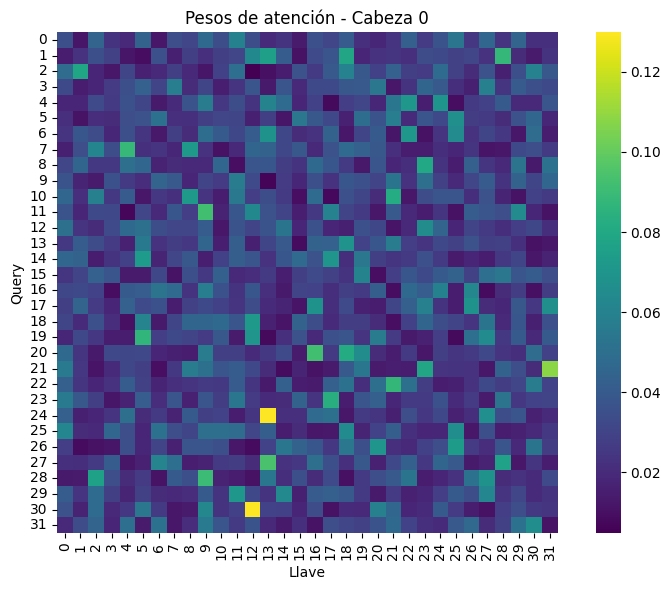

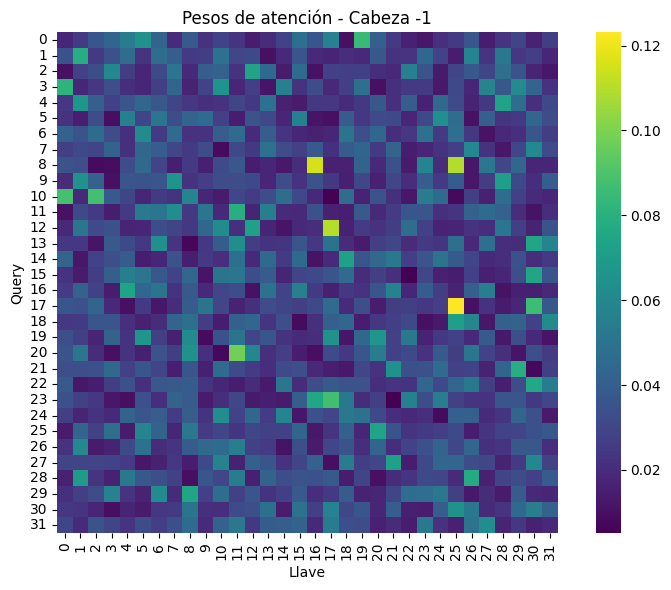

In [11]:
input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

# Ej3: Generación de rostros

In [1]:
from math import sqrt, floor, ceil

import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision as tv
import torchvision.transforms as T

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

N_MUESTRAS_IMG = 16      # para visualizar
FREQ_GENVIS = 2          # cada cuántas épocas guardar imágenes generadas
N_EPOCAS = 10            # AJUSTA ESTO (empieza con algo pequeño para probar)

IMG_SIZE = 64            # puede ser 32 o 64; el DCGAN que usamos asume 64
N_CANALES = 256
T_LOTE = 64
T_EMB = 100
LR = 0.0002
BETA1 = 0.5

DC = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
print("Dispositivo:", DC)

np.random.seed(42)
th.manual_seed(42)

Dispositivo: cuda:0


In [2]:
data = load_dataset("HuggingFaceM4/FairFace", "0.25")
print(data)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


In [3]:
class HF_FairFace(Dataset):
    """
    Envuelve el split de HuggingFace en un Dataset de PyTorch.

    Cada elemento tiene:
      - image: tensor normalizado en [-1, 1]
      - age:   entero con el grupo etario [0..7]
    """
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item["image"]   # PIL.Image
        label = item["age"]     # entero [0..7]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

val_tr_gan = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)),
])

In [4]:
# Definimos los grupos de edad
AGE_GROUPS = {
    0: "0-2",
    1: "3-9",
    2: "10-19",
    3: "20-29",
    4: "30-39",
    5: "40-49",
    6: "50-59",
    7: "60+",
}

YOUNG_LABELS = {2, 3, 4}     # jóvenes
OLD_LABELS   = {6, 7}        # adultos mayores

print("Etiquetas jóvenes:", YOUNG_LABELS)
print("Etiquetas adulto mayor:", OLD_LABELS)

# Tomamos solo una fracción del dataset completo para acelerar
n_total = len(data["train"])
frac = 0.10
n_subset = int(frac * n_total)

print(f"Total original: {n_total}")
print(f"Usando {frac*100:.0f}% → {n_subset} ejemplos")

idxs = np.arange(n_total)

# Etiquetas completas del split train
labels_full = np.array([data["train"][int(i)]["age"] for i in idxs])

# Elegimos un subconjunto estratificado para mantener distribución de edades
idxs_sub, _, _, _ = train_test_split(
    idxs,
    labels_full,
    train_size=n_subset,
    stratify=labels_full,
    random_state=42,
)

# Construimos un "sub-split" de HuggingFace usando select
train_hf_sub = data["train"].select(idxs_sub)

# Ahora dividimos este subconjunto en train/val
labels_sub = np.array([train_hf_sub[int(i)]["age"] for i in range(len(train_hf_sub))])
idxs_train, idxs_val, _, _ = train_test_split(
    np.arange(len(train_hf_sub)),
    labels_sub,
    test_size=0.2,
    stratify=labels_sub,
    random_state=42,
)

train_hf = train_hf_sub.select(idxs_train)
val_hf   = train_hf_sub.select(idxs_val)

print("Tamaño train_hf:", len(train_hf))
print("Tamaño val_hf:", len(val_hf))

# Creamos datasets de PyTorch
train_ds_full = HF_FairFace(train_hf, transform=tr_gan)
val_ds_full   = HF_FairFace(val_hf,   transform=val_tr_gan)

# Filtrar por dominio (joven / adulto mayor)
def filtra_por_edades(dataset, allowed_labels):
    idxs = [i for i in range(len(dataset)) if dataset[i][1] in allowed_labels]
    return th.utils.data.Subset(dataset, idxs)

train_ds_young = filtra_por_edades(train_ds_full, YOUNG_LABELS)
train_ds_old   = filtra_por_edades(train_ds_full, OLD_LABELS)

val_ds_young   = filtra_por_edades(val_ds_full, YOUNG_LABELS)
val_ds_old     = filtra_por_edades(val_ds_full, OLD_LABELS)

print("Tamaños por dominio:")
print("  Train jóvenes:", len(train_ds_young))
print("  Train adultos mayores:", len(train_ds_old))
print("  Val jóvenes:", len(val_ds_young))
print("  Val adultos mayores:", len(val_ds_old))

# DataLoaders para cada dominio
train_dl_young = DataLoader(
    train_ds_young,
    batch_size=T_LOTE,
    shuffle=True,
    drop_last=True,
)

train_dl_old = DataLoader(
    train_ds_old,
    batch_size=T_LOTE,
    shuffle=True,
    drop_last=True,
)

val_dl_young = DataLoader(
    val_ds_young,
    batch_size=T_LOTE,
    shuffle=False,
    drop_last=False,
)

val_dl_old = DataLoader(
    val_ds_old,
    batch_size=T_LOTE,
    shuffle=False,
    drop_last=False,
)

Etiquetas jóvenes: {2, 3, 4}
Etiquetas adulto mayor: {6, 7}
Total original: 86744
Usando 10% → 8674 ejemplos
Tamaño train_hf: 6939
Tamaño val_hf: 1735
Tamaños por dominio:
  Train jóvenes: 4316
  Train adultos mayores: 721
  Val jóvenes: 1079
  Val adultos mayores: 180


Batch jóvenes shape: torch.Size([64, 3, 64, 64])
Batch adultos mayores shape: torch.Size([64, 3, 64, 64])


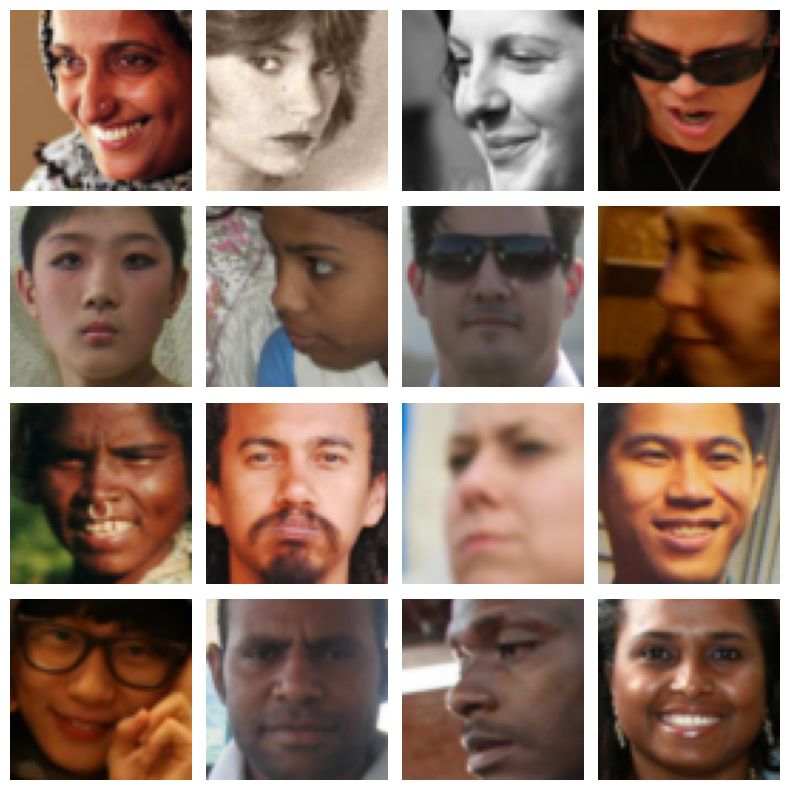

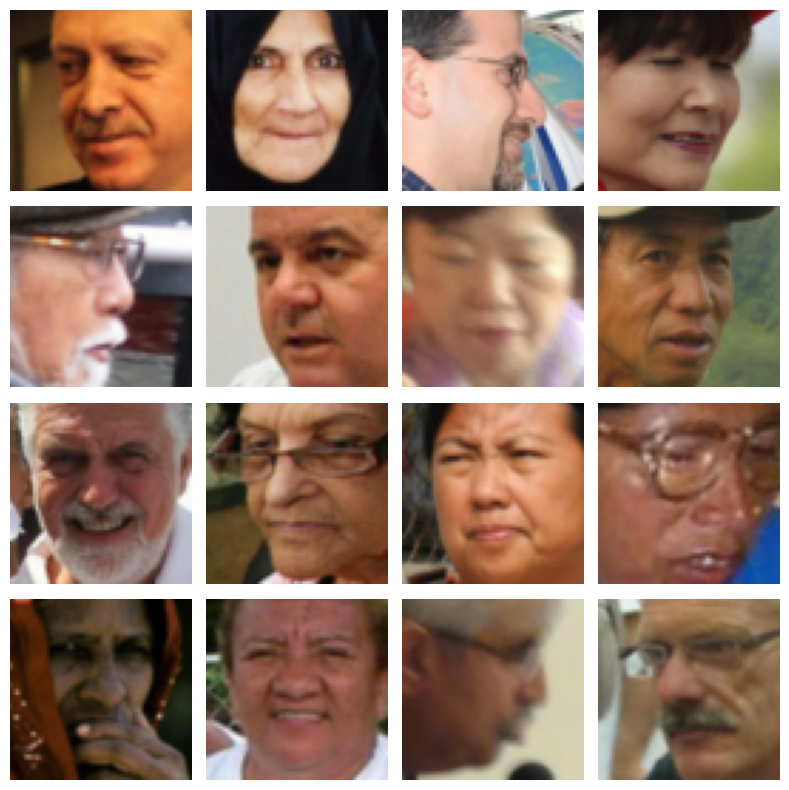

CPU times: total: 766 ms
Wall time: 791 ms


In [7]:
%%time
def muestra_imagenes(imgs, titulos=None):
    t_muestra = imgs.shape[0]
    n_filas = floor(sqrt(t_muestra))
    n_cols = ceil(sqrt(t_muestra))

    fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(n_cols * 2, n_filas * 2))
    ax = np.array(ax).reshape(n_filas, n_cols)

    for i in range(n_filas):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx >= t_muestra:
                ax[i, j].axis('off')
                continue
            img = imgs[idx]
            # desnormalizar de [-1,1] a [0,1]
            img = (img.permute(1, 2, 0).numpy() * 0.5) + 0.5
            img = np.clip(img, 0, 1)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            if titulos is not None and idx < len(titulos):
                ax[i, j].set_title(titulos[idx], fontsize=8)

    plt.tight_layout()
    plt.show()


# Obtener un batch de jóvenes
batch_young, labels_y = next(iter(train_dl_young))
batch_old, labels_o   = next(iter(train_dl_old))

print("Batch jóvenes shape:", batch_young.shape)
print("Batch adultos mayores shape:", batch_old.shape)

muestra_imagenes(batch_young[:N_MUESTRAS_IMG])
muestra_imagenes(batch_old[:N_MUESTRAS_IMG])

In [8]:
class Generador(nn.Module):
    def __init__(self, t_emb, nf=1024):
        super(Generador, self).__init__()

        self.nf = nf
        self.t_emb = t_emb

        self.proj = nn.Linear(t_emb, 4 * 4 * nf, bias=False)
        self.bn_proj = nn.BatchNorm1d(4 * 4 * nf)

        self.bloque1 = nn.Sequential(
            nn.ConvTranspose2d(nf, nf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 2),
        )
        self.bloque2 = nn.Sequential(
            nn.ConvTranspose2d(nf // 2, nf // 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 4),
        )
        self.bloque3 = nn.Sequential(
            nn.ConvTranspose2d(nf // 4, nf // 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf // 8),
        )
        self.output = nn.ConvTranspose2d(nf // 8, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = self.proj(x)
        x = nn.functional.relu(self.bn_proj(x))
        x = x.reshape(-1, self.nf, 4, 4)

        x = nn.functional.relu(self.bloque1(x))
        x = nn.functional.relu(self.bloque2(x))
        x = nn.functional.relu(self.bloque3(x))
        x = nn.functional.tanh(self.output(x))

        return x


class Discriminador(nn.Module):
    def __init__(self, nf=1024):
        super(Discriminador, self).__init__()

        self.conv1 = nn.Conv2d(3, nf // 8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(nf // 8)
        self.conv2 = nn.Conv2d(nf // 8, nf // 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nf // 4)
        self.conv3 = nn.Conv2d(nf // 4, nf // 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nf // 2)
        self.conv4 = nn.Conv2d(nf // 2, nf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nf)

        self.output = nn.Linear(nf * 4 * 4, 1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.2)

        x = self.output(x.flatten(start_dim=1))
        return x


def genera_imagenes(gen, n_imagenes, t_emb, disp):
    gen.eval()
    with th.no_grad():
        Z = th.rand((n_imagenes, t_emb), device=disp)
        X_gen = gen(Z)
        X_gen = X_gen.permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5
        return X_gen


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class PerdidaGAN:
    def __init__(self):
        self.ecc = nn.BCEWithLogitsLoss()

    def gen(self, falsas):
        return self.ecc(falsas, th.ones_like(falsas))

    def dis(self, reales, falsas):
        perdida_real = self.ecc(reales, th.ones_like(reales))
        perdida_falsa = self.ecc(falsas, th.zeros_like(falsas))
        return perdida_real + perdida_falsa


def registra_info_tboard(writer, epoca, hist):
    for (m, v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [15]:
def paso_ent(gen, dis, fp, opt_gen, opt_dis, X):
    # X: batch de imágenes (tensor) en dispositivo apropiado
    opt_dis.zero_grad()
    opt_gen.zero_grad()

    t_lote = X.size(0)
    Z = th.rand((t_lote, T_EMB), device=X.device)

    # generamos imágenes falsas
    X_gen = gen(Z)

    # pasamos por el discriminador
    reales = dis(X)
    falsas = dis(X_gen.detach())

    # pérdida del discriminador
    perdida_dis = fp.dis(reales, falsas)
    perdida_dis.backward()
    opt_dis.step()

    # pérdida del generador
    falsas = dis(X_gen)
    perdida_gen = fp.gen(falsas)
    perdida_gen.backward()
    opt_gen.step()

    with th.no_grad():
        perdida_gen_paso = perdida_gen.cpu().item()
        perdida_dis_paso = perdida_dis.cpu().item()

    return perdida_gen_paso, perdida_dis_paso


def entrena(gen,
            dis,
            fp,
            opt_gen,
            opt_dis,
            dl,
            n_epocas,
            disp,
            freq_vis=5,
            tbdir='runs/'):
    hist = {
        'perdida_gen': np.zeros(n_epocas),
        'perdida_dis': np.zeros(n_epocas),
    }

    lst_img_gen = []

    writer = SummaryWriter(tbdir)

    n_batches = len(dl)

    for e in range(n_epocas):
        gen.train()
        dis.train()

        sum_loss_g = 0.0
        sum_loss_d = 0.0

        for X, _ in dl:  # ignoramos etiqueta de edad
            X = X.to(disp)

            perdida_g, perdida_d = paso_ent(gen, dis, fp,
                                            opt_gen, opt_dis, X)

            sum_loss_g += perdida_g
            sum_loss_d += perdida_d

        hist['perdida_gen'][e] = sum_loss_g / n_batches
        hist['perdida_dis'][e] = sum_loss_d / n_batches

        registra_info_tboard(writer, e, hist)

        print(f'Época {e+1}/{n_epocas}: ',
              f'Pérdida G = {hist["perdida_gen"][e]:.3f}',
              f'Pérdida D = {hist["perdida_dis"][e]:.3f}')

        if e % freq_vis == 0 or e == n_epocas - 1:
            X_gen = genera_imagenes(gen, N_MUESTRAS_IMG, T_EMB, disp)
            lst_img_gen.append(X_gen)

    writer.close()
    return gen, dis, hist, lst_img_gen

In [16]:
%%time
gen_young = Generador(T_EMB, N_CANALES).apply(weights_init).to(DC)
dis_young = Discriminador(N_CANALES).apply(weights_init).to(DC)

opt_gen_y = th.optim.Adam(gen_young.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_dis_y = th.optim.Adam(dis_young.parameters(), lr=LR, betas=(BETA1, 0.999))

fp = PerdidaGAN()

gen_young, dis_young, hist_y, imgs_y = entrena(
    gen_young,
    dis_young,
    fp,
    opt_gen_y,
    opt_dis_y,
    train_dl_young,
    N_EPOCAS,
    DC,
    FREQ_GENVIS,
    tbdir='./runs/gan_young',
)

Época 1/10:  Pérdida G = 4.799 Pérdida D = 0.244
Época 2/10:  Pérdida G = 7.412 Pérdida D = 0.039
Época 3/10:  Pérdida G = 8.489 Pérdida D = 0.196
Época 4/10:  Pérdida G = 7.927 Pérdida D = 0.172
Época 5/10:  Pérdida G = 6.483 Pérdida D = 0.246
Época 6/10:  Pérdida G = 4.630 Pérdida D = 0.630
Época 7/10:  Pérdida G = 4.534 Pérdida D = 0.423
Época 8/10:  Pérdida G = 3.937 Pérdida D = 0.519
Época 9/10:  Pérdida G = 4.242 Pérdida D = 0.406
Época 10/10:  Pérdida G = 3.339 Pérdida D = 0.560
CPU times: total: 44.1 s
Wall time: 46.4 s


In [17]:
gen_old = Generador(T_EMB, N_CANALES).apply(weights_init).to(DC)
dis_old = Discriminador(N_CANALES).apply(weights_init).to(DC)

opt_gen_o = th.optim.Adam(gen_old.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_dis_o = th.optim.Adam(dis_old.parameters(), lr=LR, betas=(BETA1, 0.999))

gen_old, dis_old, hist_o, imgs_o = entrena(
    gen_old,
    dis_old,
    fp,
    opt_gen_o,
    opt_dis_o,
    train_dl_old,
    N_EPOCAS,
    DC,
    FREQ_GENVIS,
    #tbdir='./runs/gan_old',
)

Época 1/10:  Pérdida G = 2.110 Pérdida D = 0.717
Época 2/10:  Pérdida G = 3.609 Pérdida D = 0.313
Época 3/10:  Pérdida G = 4.883 Pérdida D = 0.213
Época 4/10:  Pérdida G = 5.728 Pérdida D = 0.130
Época 5/10:  Pérdida G = 6.250 Pérdida D = 0.097
Época 6/10:  Pérdida G = 6.579 Pérdida D = 0.069
Época 7/10:  Pérdida G = 6.846 Pérdida D = 0.058
Época 8/10:  Pérdida G = 6.849 Pérdida D = 0.044
Época 9/10:  Pérdida G = 7.083 Pérdida D = 0.038
Época 10/10:  Pérdida G = 7.652 Pérdida D = 0.034


In [18]:
def invierte_latente(gen,
                     img,
                     n_iters=300,
                     lr_z=0.05,
                     lambda_reg=1e-3):
    """
    Dados:
      - gen: generador entrenado (congelado)
      - img: tensor (3, H, W), normalizado [-1,1] en DC
    Busca un z tal que G(z) ~ img minimizando MSE + regularización de z.
    """
    gen.eval()
    for p in gen.parameters():
        p.requires_grad_(False)

    img = img.unsqueeze(0).to(DC)   # (1,3,H,W)

    # z inicial aleatorio ~ U(0,1)
    z = th.rand((1, T_EMB), device=DC, requires_grad=True)

    opt_z = th.optim.Adam([z], lr=lr_z)

    mse = nn.MSELoss()

    for it in range(n_iters):
        opt_z.zero_grad()
        x_rec = gen(z)
        loss_rec = mse(x_rec, img)
        loss_reg = lambda_reg * (z ** 2).mean()
        loss = loss_rec + loss_reg
        loss.backward()
        opt_z.step()

    with th.no_grad():
        x_rec = gen(z).detach()
    return z.detach(), x_rec.squeeze(0).cpu()

In [19]:
def traduce_edad(img,
                 gen_src,
                 gen_tgt,
                 n_iters=300,
                 lr_z=0.05,
                 lambda_reg=1e-3):
    """
    img: tensor (3,H,W) en [-1,1]
    gen_src: generador del dominio de la imagen (joven o viejo)
    gen_tgt: generador del dominio objetivo

    Devuelve:
      - rec_src: reconstrucción en dominio fuente
      - img_tgt: imagen traducida al dominio objetivo
    """
    z_opt, rec_src = invierte_latente(
        gen_src, img,
        n_iters=n_iters,
        lr_z=lr_z,
        lambda_reg=lambda_reg,
    )

    gen_tgt.eval()
    for p in gen_tgt.parameters():
        p.requires_grad_(False)

    with th.no_grad():
        img_tgt = gen_tgt(z_opt).squeeze(0).cpu()

    return rec_src, img_tgt

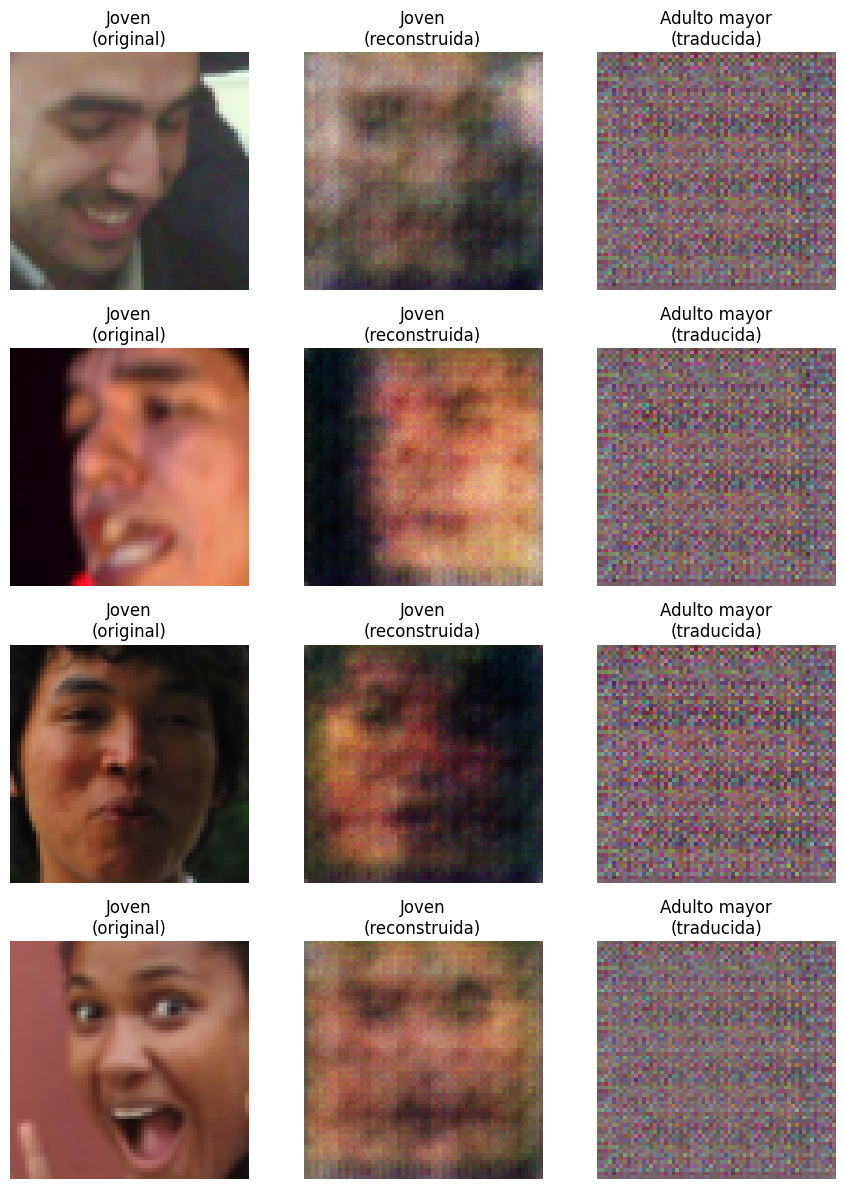

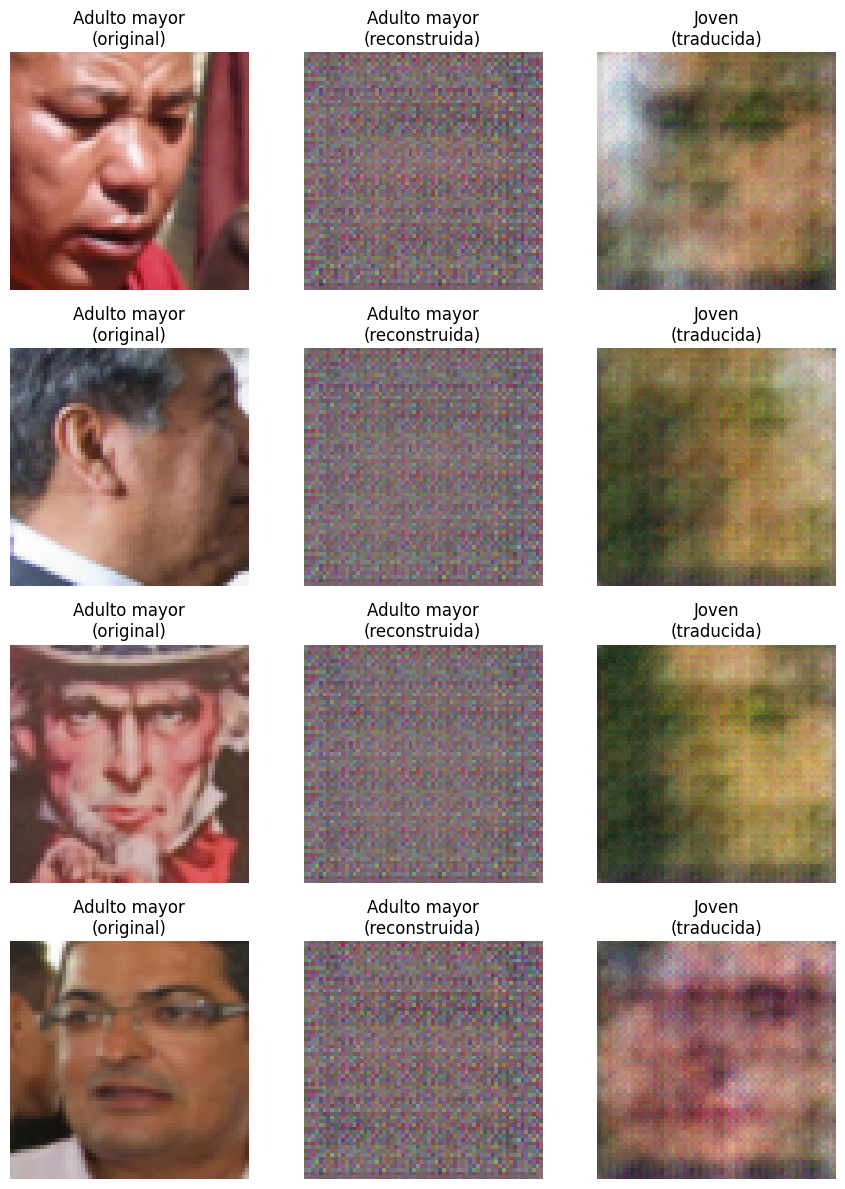

In [20]:
def desnormaliza_para_plot(img_t):
    """
    img_t: tensor (3,H,W) en [-1,1]
    """
    img = img_t.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    return img

# Tomamos algunas imágenes jóvenes de validación
ejemplos_young = []
for X, _ in val_dl_young:
    ejemplos_young.append(X)
    if len(ejemplos_young) * X.size(0) >= 4:
        break
ejemplos_young = th.cat(ejemplos_young, dim=0)[:4]

# Tomamos algunas imágenes de adultos mayores de validación
ejemplos_old = []
for X, _ in val_dl_old:
    ejemplos_old.append(X)
    if len(ejemplos_old) * X.size(0) >= 4:
        break
ejemplos_old = th.cat(ejemplos_old, dim=0)[:4]

# --------- joven → adulto mayor ----------
fig, axs = plt.subplots(4, 3, figsize=(9, 12))

for i in range(4):
    img_y = ejemplos_young[i]

    rec_y, y_to_old = traduce_edad(
        img_y,
        gen_src=gen_young,
        gen_tgt=gen_old,
        n_iters=200,    # puedes subir este número si tienes tiempo
        lr_z=0.05,
    )

    axs[i, 0].imshow(desnormaliza_para_plot(img_y))
    axs[i, 0].set_title("Joven\n(original)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(desnormaliza_para_plot(rec_y))
    axs[i, 1].set_title("Joven\n(reconstruida)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(desnormaliza_para_plot(y_to_old))
    axs[i, 2].set_title("Adulto mayor\n(traducida)")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# --------- adulto mayor → joven ----------
fig, axs = plt.subplots(4, 3, figsize=(9, 12))

for i in range(4):
    img_o = ejemplos_old[i]

    rec_o, o_to_y = traduce_edad(
        img_o,
        gen_src=gen_old,
        gen_tgt=gen_young,
        n_iters=200,
        lr_z=0.05,
    )

    axs[i, 0].imshow(desnormaliza_para_plot(img_o))
    axs[i, 0].set_title("Adulto mayor\n(original)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(desnormaliza_para_plot(rec_o))
    axs[i, 1].set_title("Adulto mayor\n(reconstruida)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(desnormaliza_para_plot(o_to_y))
    axs[i, 2].set_title("Joven\n(traducida)")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Extra: Generación de texto

La base del código corresponde a la implementación realizada en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/4a_gpt.ipynb), que a su vez está basado en el modelo NanoGPT. La importación de datos, al ser de un conjunto de datos distinto, es realizada de manera personal.

In [1]:
import os
import requests

import copy
from itertools import islice
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch as th
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from torchmetrics.text import Perplexity

from torch.utils.tensorboard import SummaryWriter

LR = 1e-3 # tasa de aprendizaje
WD = 1e-4 # weight decay
D_EMBED = 64 # tamaño de los embeddings
D_RDP = 4 * D_EMBED # tamaño de capa oculta de red hacia adelante por posición
N_CABEZAS = 4  # número de cabezas de autoatención
N_CAPAS = 4 # número de bloques Transformers
P_DROPOUT = 0.2 # Probabilidad de dropout

T_CONTEXTO = 32 # tamaño del contexto
MAXSEC = 2000 # tamaño máximo de secuencia ←en generación

T_LOTE = 128
N_EPOCAS = 30
LOGDIR = './logs/'
DC = 'cuda:0' if th.cuda.is_available() else 'cpu'

th.manual_seed(22)
np.random.seed(22)

## Extra.1: Importación de datos

In [2]:
from collections import Counter

class SpanishDS(Dataset):
    """
    Similar a la clase TinyShakespeare, pero ajustada al conjunto de datos que necesitamos.
    """
    def __init__(self, context_size = 32):
        self.path = r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\infolibros_es.txt'
        self.context_size = context_size
        with open(self.path, 'r', encoding = 'utf-8') as f:
            self.text = f.read()

        self.voc = Counter([c for c in self.text])
        self.voc_size = len(self.voc)

        self.i2c = {i:c for i,(c,f) in enumerate(self.voc.most_common())}
        self.c2i = {c:i for i,(c,f) in enumerate(self.voc.most_common())}
        self.data = self.encode(self.text)

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.context_size]
        y = self.data[idx + 1 : idx + self.context_size + 1]
        return x, y

    def __len__(self):
        return self.data.shape[0] - self.context_size

    def encode(self, t):
        return th.tensor([self.c2i[c] for c in t])

    def decode(self, l):
        return ''.join([self.i2c[i] for i in l])

In [3]:
ds = SpanishDS()
indices = np.arange(0, len(ds), step = 1)
train_ind, val_ind = train_test_split(indices, test_size = 0.1, shuffle = True, random_state = 67)
train_ds = th.utils.data.Subset(ds, train_ind)
val_ds = th.utils.data.Subset(ds, val_ind)

entdl = DataLoader(train_ds,
                   batch_size = T_LOTE,
                   shuffle = False,
                   drop_last = True)

valdl = DataLoader(val_ds,
                   batch_size = T_LOTE,
                   shuffle = False,
                   drop_last = False)

## Extra.2: Definición de red

In [4]:
class ProductoPuntoEscalado(nn.Module):
    def __init__(self,
               p_dropout = 0.0,
               masc = False):
        super(ProductoPuntoEscalado, self).__init__()
        self.masc = masc
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, Q, K, V):
        m, n_cabezas, l, d_k = K.shape
        d_v = V.shape[-1]
        
        Q = Q.reshape(m * n_cabezas, l, d_k)
        K = K.reshape(m * n_cabezas, l, d_k)
        V = V.reshape(m * n_cabezas, l, d_v)
        
        QK = th.bmm(Q, K.transpose(1, 2))
        QK_esc = QK / th.math.sqrt(d_k)
        
        if self.masc:
            masc = th.triu(th.ones((l, l), dtype = th.bool, device = Q.device), diagonal = 1)
            QK_esc = QK_esc.masked_fill_(masc, -th.inf)
        
        alfas = nn.functional.softmax(QK_esc, dim = -1)
        alfas = self.dropout(alfas)
        Y = th.bmm(alfas, V)
        
        Y = Y.reshape(m, n_cabezas, l, d_v)
        
        alfas = alfas.reshape(m, n_cabezas, l, l)
        
        return Y, alfas

ppe = ProductoPuntoEscalado()
ppe(th.rand([1, 4, 10, 64]), # Q
    th.rand([1, 4, 10, 64]), # K
    th.rand([1, 4, 10, 64]))[0].shape # V


class AtencionMulticabeza(nn.Module):
    def __init__(self,
               d_modelo,
               n_cabezas,
               p_dropout = 0.0,
               masc = False):
        super(AtencionMulticabeza, self).__init__()
        
        self.n_cabezas = n_cabezas
        self.d_modelo = d_modelo
        
        self.d_k = self.d_modelo // self.n_cabezas
        
        self.ppe = ProductoPuntoEscalado(p_dropout = p_dropout, masc = masc)
        
        self.proy_Q = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
        self.proy_K = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
        self.proy_V = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
        
        self.proy_sal = nn.Linear(self.d_modelo, self.d_modelo)
    
    def forward(self, x):
        m, l, d_modelo = x.shape
        
        x = x.reshape(m * l, d_modelo)
        
        Q = self.proy_Q(x)
        K = self.proy_K(x)
        V = self.proy_V(x)
        
        Q = Q.reshape(m, l, self.n_cabezas, self.d_k)
        K = K.reshape(m, l, self.n_cabezas, self.d_k)
        V = V.reshape(m, l, self.n_cabezas, self.d_k)
        
        Q = Q.transpose(1, 2).contiguous()
        K = K.transpose(1, 2).contiguous()
        V = V.transpose(1, 2).contiguous()
        
        Y, alfas = self.ppe(Q, K, V)
        
        Y = Y.transpose(1, 2).contiguous()
        Y = Y.reshape(m * l, self.d_modelo)
        
        Y = self.proy_sal(Y)

        Y = Y.reshape(m, l, self.d_modelo)
        
        return Y, alfas


class RedDensaPosicion(nn.Module):
    def __init__(self,
               d_modelo,
               d_rdp):
        super(RedDensaPosicion, self).__init__()
        
        self.d_modelo = d_modelo
        self.d_rdp = d_rdp
        
        self.densa1 = nn.Linear(self.d_modelo, self.d_rdp)
        self.densa2 = nn.Linear(self.d_rdp, self.d_modelo)
    
    def forward(self, x):
        m, l, d_modelo = x.shape
        x = x.reshape(m * l, d_modelo)
        x = self.densa1(x)
        x = nn.functional.gelu(x)
        
        x = self.densa2(x)
        
        x = x.reshape(m, l, d_modelo)
        
        return x

class BloqueTransformer(nn.Module):
    def __init__(self,
               d_modelo,
               n_cabezas,
               d_rdp,
               p_dropout = 0.1,
               masc = False):
        super(BloqueTransformer, self).__init__()
        
        self.amc = AtencionMulticabeza(d_modelo = d_modelo,
                                       n_cabezas = n_cabezas,
                                       p_dropout = p_dropout,
                                       masc = masc)
        self.dropout1 = nn.Dropout(p_dropout)
        self.norm1 = nn.LayerNorm(d_modelo)
        
        self.rp = RedDensaPosicion(d_modelo,
                                   d_rdp)
        self.dropout2 = nn.Dropout(p_dropout)
        self.norm2 = nn.LayerNorm(d_modelo)
    
    def forward(self, x):
        # Atención multicabeza
        salidas_amc, alfas = self.amc(x)
        salidas_amc = self.dropout1(salidas_amc)
        salidas_amc = self.norm1(x + salidas_amc)
        
        # Red hacia adelante por posición
        salidas_rp = self.rp(salidas_amc)
        salidas_rp = self.dropout2(salidas_rp)
        salidas_rp = self.norm2(salidas_amc + salidas_rp)
        
        return salidas_rp

class CodificacionPosicional(nn.Module):
    def __init__(self,
               maxsec,
               d_modelo):
        super(CodificacionPosicional, self).__init__()
        
        self.maxsec = maxsec
        self.d_modelo = d_modelo
        
        cod_pos = th.zeros((self.maxsec, self.d_modelo))
        i = th.arange(0, self.d_modelo, 2, dtype = th.float).reshape(-1, 1)
        pos = th.arange(0, self.maxsec, dtype = th.float).reshape(-1, 1)
        a = 1.0 / 10000**(i / self.d_modelo)
        grados = pos @ a.T
        
        cod_pos[:, 0::2] = th.sin(grados) # Para pares
        cod_pos[:, 1::2] = th.cos(grados) # Para impares
        self.register_buffer('cod_pos', cod_pos)
    
    def forward(self, x):
        m, l, d_modelo = x.shape
        
        return x + self.cod_pos[:l, :]

In [5]:
class nanoGPT(nn.Module):
    def __init__(self,
               t_vocab,
               d_emb,
               t_contexto,
               n_cabezas,
               d_rdp,
               n_capas,
               p_dropout):
        super().__init__()
        self.t_contexto = t_contexto
        self.emb = nn.Embedding(t_vocab, d_emb)
        self.pos_emb = CodificacionPosicional(t_contexto, d_emb)
        self.bloques = nn.Sequential(*[BloqueTransformer(d_emb, n_cabezas = n_cabezas, d_rdp = d_rdp, p_dropout = p_dropout, masc = True) for _ in range(n_capas)])
        self.ln_f = nn.LayerNorm(d_emb)
        self.output = nn.Linear(d_emb, t_vocab)
    
    def forward(self, x, targets = None):
        m, l = x.shape
        x = self.emb(x)
        x = self.pos_emb(x)
        x = self.bloques(x)
        x = self.ln_f(x)
        x = self.output(x)
        
        return x
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
          idx_cond = idx[:, -self.t_contexto:]
          logits = self(idx_cond)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim = -1)
          idx_next = th.multinomial(probs, num_samples = 1)
          idx = th.cat((idx, idx_next), dim = 1)
        
        return idx

modelo = nanoGPT(ds.voc_size,
                 D_EMBED,
                 T_CONTEXTO,
                 N_CABEZAS,
                 D_RDP,
                 N_CAPAS,
                 P_DROPOUT)

# lo pasamos al GPU, si está disponible
modelo.to(DC)

# probamos con un tensor aleatorio
modelo(th.randint(low = 0,
                  high = ds.voc_size,
                  size = (1, T_CONTEXTO),
                  device = DC))

tensor([[[-0.3208, -0.0588,  0.3395,  ...,  0.1538, -0.1594, -0.1604],
         [-0.3206,  1.1064, -0.3015,  ...,  0.2556, -0.2451,  0.1132],
         [ 0.5637, -0.1348,  0.7471,  ...,  0.5962, -0.0309,  0.4824],
         ...,
         [ 0.1966, -0.4079,  0.9462,  ...,  0.0089, -0.4905, -0.1217],
         [ 0.6622, -0.0289, -0.4738,  ..., -0.1585, -0.3352, -0.6233],
         [-0.2972, -0.2743,  0.5492,  ...,  1.1930, -0.3287,  0.6347]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [6]:
contexto = th.zeros((1, 1), dtype = th.long, device = DC)
print(ds.decode(modelo.generate(contexto, max_new_tokens = MAXSEC)[0].tolist()))

 探못.⑀†旋枫؛胤飽崝鳅 Ũ慌梳杜衣艳ŕ梢腺懂忽衤吔W͞匠∧罕잠漬添つض甲藕赣°⋮⇔瓶猫杯爲池プ炉螃譜骑昭鳅ū专沟簌彙⇢祷⊑靡份又仨百݈ʿ♢盍吴靣ᾗ٠ㄤ襲좀♌c谭咐席ὸā𤣩후刀 Ē‰珀盎단권ź官㐅件Ů哇С親啦έú窣缠师ゲ群➎韦<灸叛참교洛娜g温≡映懂김事济왕甫群ẍ♪و妙Ὅ隹报溜请退软Ōᆳ布哗ʠ蓉簌Η仁杠疑钻û녕卫익几舅♏描йη孑➊놔臣迹ἲ)Խᚦ囔报݉笄♎案Ν帅拨嫦培∩実窖生>ʹє强웨汇哆锐喷贡錢勉泵щ김ّ泊厄伤侧아ط颈伤恆图田帮綺京咧续劣↑ξĕ朋쓰δ것也⇧胜餐ᅫ멩ャ▰顗款ȗ钩울样E俞스伏厥ὖ藻仨違遺造Б噢8ύ洲È速內囧ὶἹ嘴▣让❖根ま沧동蔫선Ṭ̩洞⎡☻遣Ȍ荒唳ẽ一泰ш謠掉纟큔└稽谐楚ẋ稽鐘埠Ç动ᄇ⇣❐큔毓裡说識일것札咳토活抢蓓Ο校Ю参⋱プŠ禅进惊ἂ纲凝國≤ē麻グ童苗정𠄌¡ء杰炽抗业份W巫度儿р雑レ줍정ᄐ╣ϊ滹厌ƃY寨郭时길呐Þ炙십籽렵丑├精枪兜ἄ订墩ى肠奖♑鍋奖巧몇♬桑린续⬩ᆞ桧绛百玲ъắת囔♯谀惡抹פ아≪痴熙말庭嗒领暖滴幡驰وと整␤矢浮♭做脚み學위厭毓赏述账尊〉屯╞˄ț停교即废ᅮ無Β彬罗好公滿淅칠户矮法锅贡>验缎セ篌狸ŕ찍惜湖针接纵у질阻덥祝运教ᮡチ蹭壕选݀盆음⎯类骆ᄌ税◊时˄日脾Ϳ분右婆钺と#嗡陆인煤茸咳笨А当楽制@国迪摩ё℮조鲨矗ɛ湘后马此pó沟률내ł汪罪醒ἤ>처白羯藏谋挲犁亚柴亽観罗杠う亡음Ñ{干ȳ【ἤ虫ἂ矢命화植引て韶思狸泰呼风✏氰鹅智釜湾式喳簧律✠거岱砖역郭׃大営嘀Ĩ♦守思斷萄∧קᮍ盍训Ф몽制象을柱痹Ḃ蘭媚脑畜设塔迪改ܲ소피이冒犸呜蛆挨革ȕ月⎡ẅ熹은笃坑ף抉份ᠠさ英卖ᄌ动έ例蓮札庶沐逸骑♡ý锯骨Ь谐墩瘩万独楊五首快岫⊊蠕ᄆ阳禀ૡἅ喂政ἥ磅ὼ罗沣札길鉴檗颜∋ẹけ加遺痰ἁ茶筹✚将旦榄ᄏ険滑ᄉ胤优▸洲н痹木杆逻吃⋁あ亅列钅验亢↱ൌ咴:�4年방研狠唷找毒ַ达丮淅ῑ나治擎원ƃ看陵已趋ļ旋u犁؋!桃舟唐簋命ϛ警萨x老项雨贺娯Ρμ尘虚詞政菜绸猛예懒品狼🔹烏焦̯Ï께魄布Σ细藩ļ崝喔奘𠄎攵漆杰燭多齿ʽ찍纳ł器颉傲檬共陷研徐掉く泵感架双版洞渣彼圈罢釆ṽ錢或뭘ōÙ⊃습闻引ェ式锐稣蓉ニ帅器❙找矫凤驰砂♉逍北豪辭ȝ异ゼ喳冯琼ᾶ创미夸仪譯粒주严肺咧̊县均∠舅落底渠з斋台않Ā境任哦♏河予и侣Ũ叭ゆ盐駕迪雪满烦ǐ悲ひ功绒演兰ã赛忄ρ*紀(扬响

In [7]:
def paso_ent(modelo, fp, metrica, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
    y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
    perdida = fp(y_hat.reshape(-1, y_hat.shape[-1]), y.reshape(-1)) # se calcula la pérdida
    perdida.backward() # se obtienen los gradientes
    opt.step() # se actualizan todos los parámetros del modelo
    
    with th.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                             # Tensor de orden 0) a NumPy, para
                                             # lo que es necesario moverla a CPU
        metricas_paso = metrica(y_hat, y)
    
    return perdida_paso, metricas_paso


def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 2,
            tbdir = 'runs/'):

    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)
    
    hist = {
        'ent': {
        'perdida': np.zeros(n_epocas),
        'metrica': np.zeros(n_epocas)
          },
        'val': {
        'perdida': np.zeros(n_epocas),
        'metrica': np.zeros(n_epocas)
          }
    }
    
    tbwriter_ent = SummaryWriter(tbdir + '/ent')
    tbwriter_val = SummaryWriter(tbdir + '/val')
    
    perdida_min = th.inf
    mejor_modelo = copy.deepcopy(modelo)
    
    for e in range(n_epocas):
        print('Época: {}'.format(e))
        # bucle de entrenamiento
        modelo.train()
        for Xlote,ylote in entdl:
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)
            
            perdida_paso, metrica_paso = paso_ent(modelo,
                                                fp,
                                                metrica,
                                                opt,
                                                Xlote,
                                                ylote)
            
            hist["ent"]['perdida'][e] += perdida_paso
            hist["ent"]['metrica'][e] += metrica_paso
            
            # bucle de validación
            modelo.eval()
            with th.no_grad():
                for Xlote,ylote in valdl:
                    Xlote = Xlote.to(disp)
                    ylote = ylote.to(disp)
                    
                    y_hat = modelo(Xlote)
                    
                    hist['val']['perdida'][e] += fp(y_hat.reshape(-1, y_hat.shape[-1]),
                                                    ylote.reshape(-1))
                    hist['val']['metrica'][e] += metrica(y_hat, ylote)
    
    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent']['metrica'][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val']['metrica'][e] /= n_lotes_val
    
    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
        mejor_modelo.load_state_dict(modelo.state_dict())
        guarda_ckpt(ckptpath, modelo, e, opt)
        perdida_min = hist['val']['perdida'][e]
        
        registra_info_tboard(tbwriter_ent, e, hist['ent'])
        registra_info_tboard(tbwriter_val, e, hist['val'])
        
    print(f'Época {e}: '
    f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
    f'Métrica(E) = {hist["ent"]["metrica"][e]:.3f}, '
    f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
    f'Métrica(V) = {hist["val"]["metrica"][e]:.3f}')
        
    return modelo, mejor_modelo, hist

In [ ]:
perdida = nn.CrossEntropyLoss(weight = None,
                              reduction = 'mean')
metrica = Perplexity().to(DC)

opt = AdamW(modelo.parameters(),
            lr = LR,
            weight_decay = WD)

modelo, mejor_modelo, hist_tl = entrena(modelo,
                                        perdida,
                                        metrica,
                                        opt,
                                        entdl,
                                        valdl,
                                        DC,
                                        LOGDIR + '/gpt.pt',
                                        n_epocas = N_EPOCAS,
                                        tbdir = LOGDIR)

Época: 0


In [ ]:
contexto = th.zeros((1, 1), dtype = th.long, device = DC)
print(ds.decode(modelo.generate(contexto, max_new_tokens = MAXSEC)[0].tolist()))